In [1]:
# Generate NCI reports for given projects
import os
import sys

# Insert your local paths here
sys.path.append(f'/g/data/gb02/public/code/nci_resource_tools')
sys.path.append(f'/g/data/gb02/public/code/nci-tools/src/ncitools')

In [2]:
import pandas as pd
import re
import io
import subprocess 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
from matplotlib.cm import tab20, Dark2, Set2
from IPython.display import display, Markdown
import datetime as dt
import numpy as np
import itables

from nci_account import nci_account
from nci_resource_tools.read_project import retrieve_project_data, create_storage_df
from nci_resource_tools.check_allocation import check_allocation, create_user_table
from nci_resource_tools.check_storage import convert_size_to_bytes, find_largest_users
from config import *

In [3]:
SU_df_dict1, grant_dict, storage_dict = retrieve_project_data()

In [4]:
SU_df_dict = {}
for i,project in enumerate(SU_df_dict1.keys()):
    
    user_totals = SU_df_dict1[project].groupby('user')['usage'].sum()
    top_users = user_totals.nlargest(5)
    if len(user_totals) > 5:
        other_total = user_totals.sort_values(ascending=False).iloc[5:].sum()
        top_users['other users'] = other_total
    SU_df_dict[project] = top_users



In [5]:
du_dict = find_largest_users(COE_PROJECTS)
user_storage_dict = {}
for project in COE_PROJECTS:
    
    user_totals = du_dict[project].groupby('USER')['TOTAL SIZE'].sum()
    top_users = user_totals.nlargest(5)
    if len(user_totals) > 5:
        other_total = user_totals.sort_values(ascending=False).iloc[5:].sum()
        top_users['other users'] = other_total
    user_storage_dict[project] = top_users

user_storage_numeric=pd.concat(user_storage_dict)

In [6]:
colormap = list(tab20.colors) + list(Dark2.colors) + list(Set2.colors) #40 colors should be enough
color_cycle = itertools.cycle(colormap)
users = set()

for i,project in enumerate(SU_df_dict.keys()):
    users.update(SU_df_dict[project].index.values)

for project in COE_PROJECTS:
    users.update(user_storage_numeric[project].index.values)

user_colors = {user: next(color_cycle) for user in sorted(users)}
default_color = (0.5, 0.5, 0.5) #in case a user is not the list


# Usage

## Figures {.tabset}

### SU usage

#### Column {width=20%}

In [7]:
allocation_df=pd.read_csv('su_request_Q42025.csv',skipinitialspace=True)
Index=pd.MultiIndex.from_frame(allocation_df[['project','user']])
allocation_df.set_index(Index,inplace=True)
allocation_df = allocation_df['allocation'].to_frame()

In [8]:
allocation_df

allocation
project user              
gb02    ARE             50
        pag548         500
        sl5165         500
        sg7549         200
        pc2687          60
fy29    ARE             50
        bw6466         300
        mjl561         175
if69    ARE             50
        td6427          50
        mr4682          60
        rq1991          50
        cb4968         145
        qo9901          30
ng72    ARE             50
        jpe561          20
        lk5320         352
        cd3007          50
        oa1927          20

In [9]:
alloc_df_dict = check_allocation(grant_dict,
                                 SU_df_dict1,
                                 allocation_df)

CRITICAL : sl5165 has consumed 115.95% of their gb02 SU allocation
CRITICAL : qo9901 has consumed 115.90% of their if69 SU allocation


#### Column {width=20%}

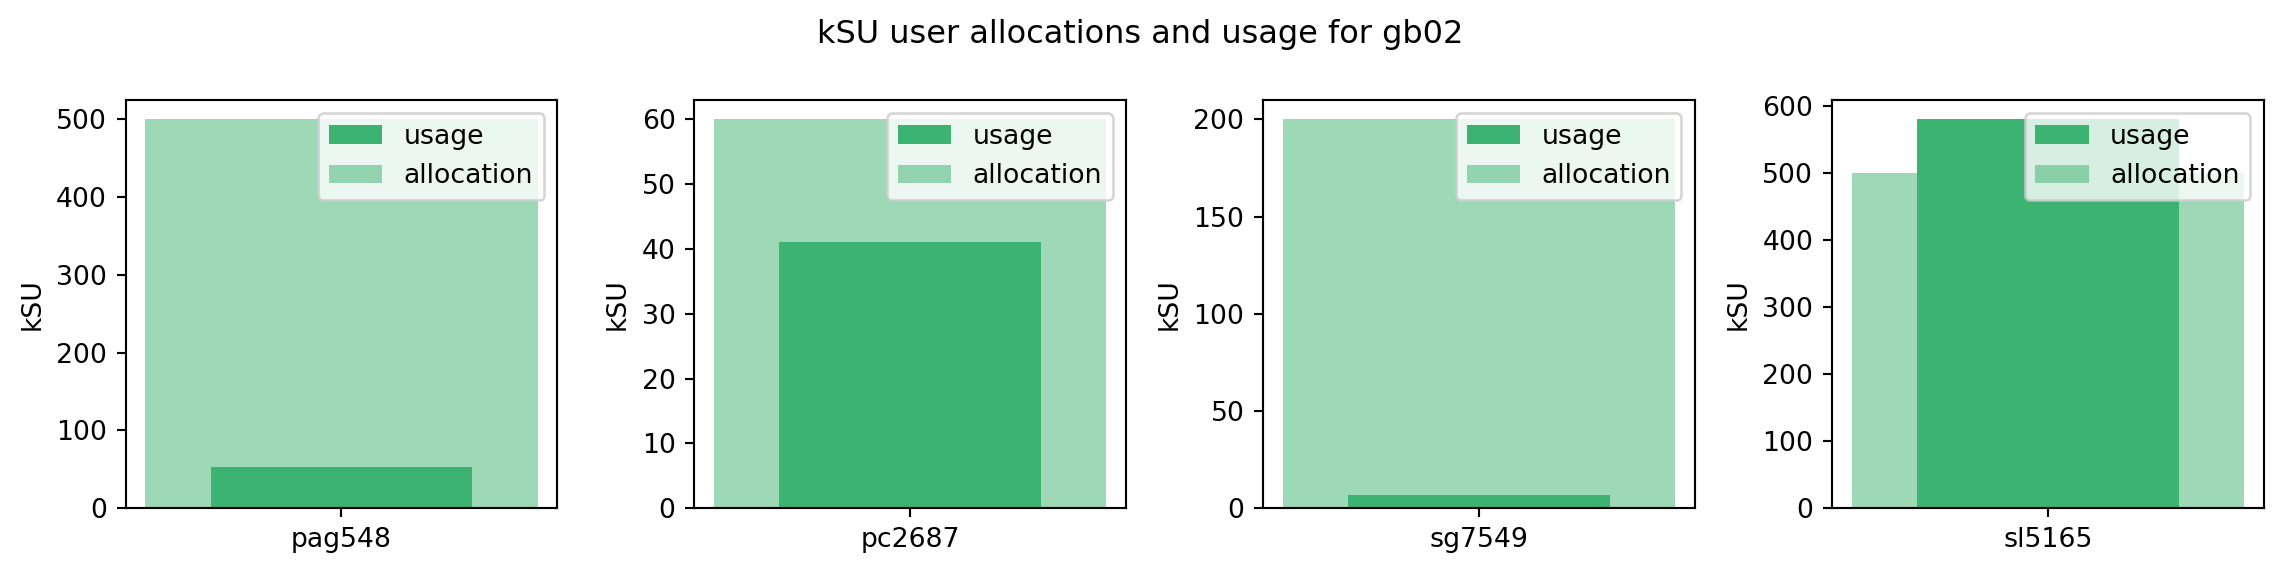

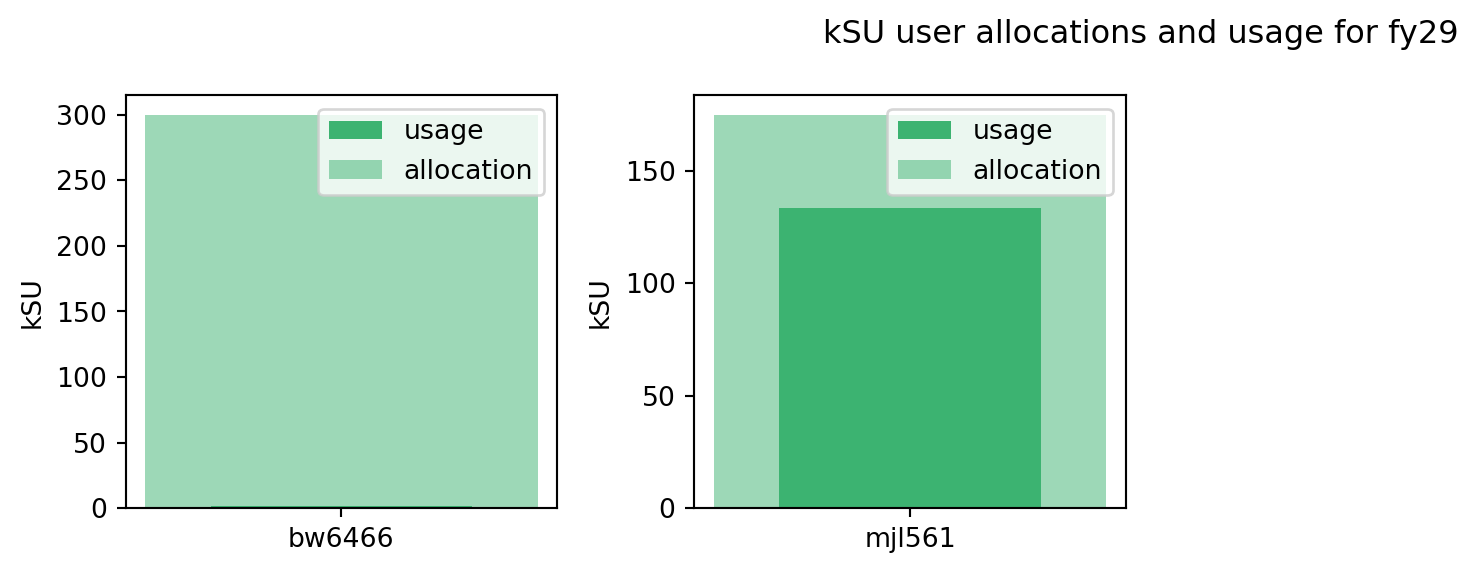

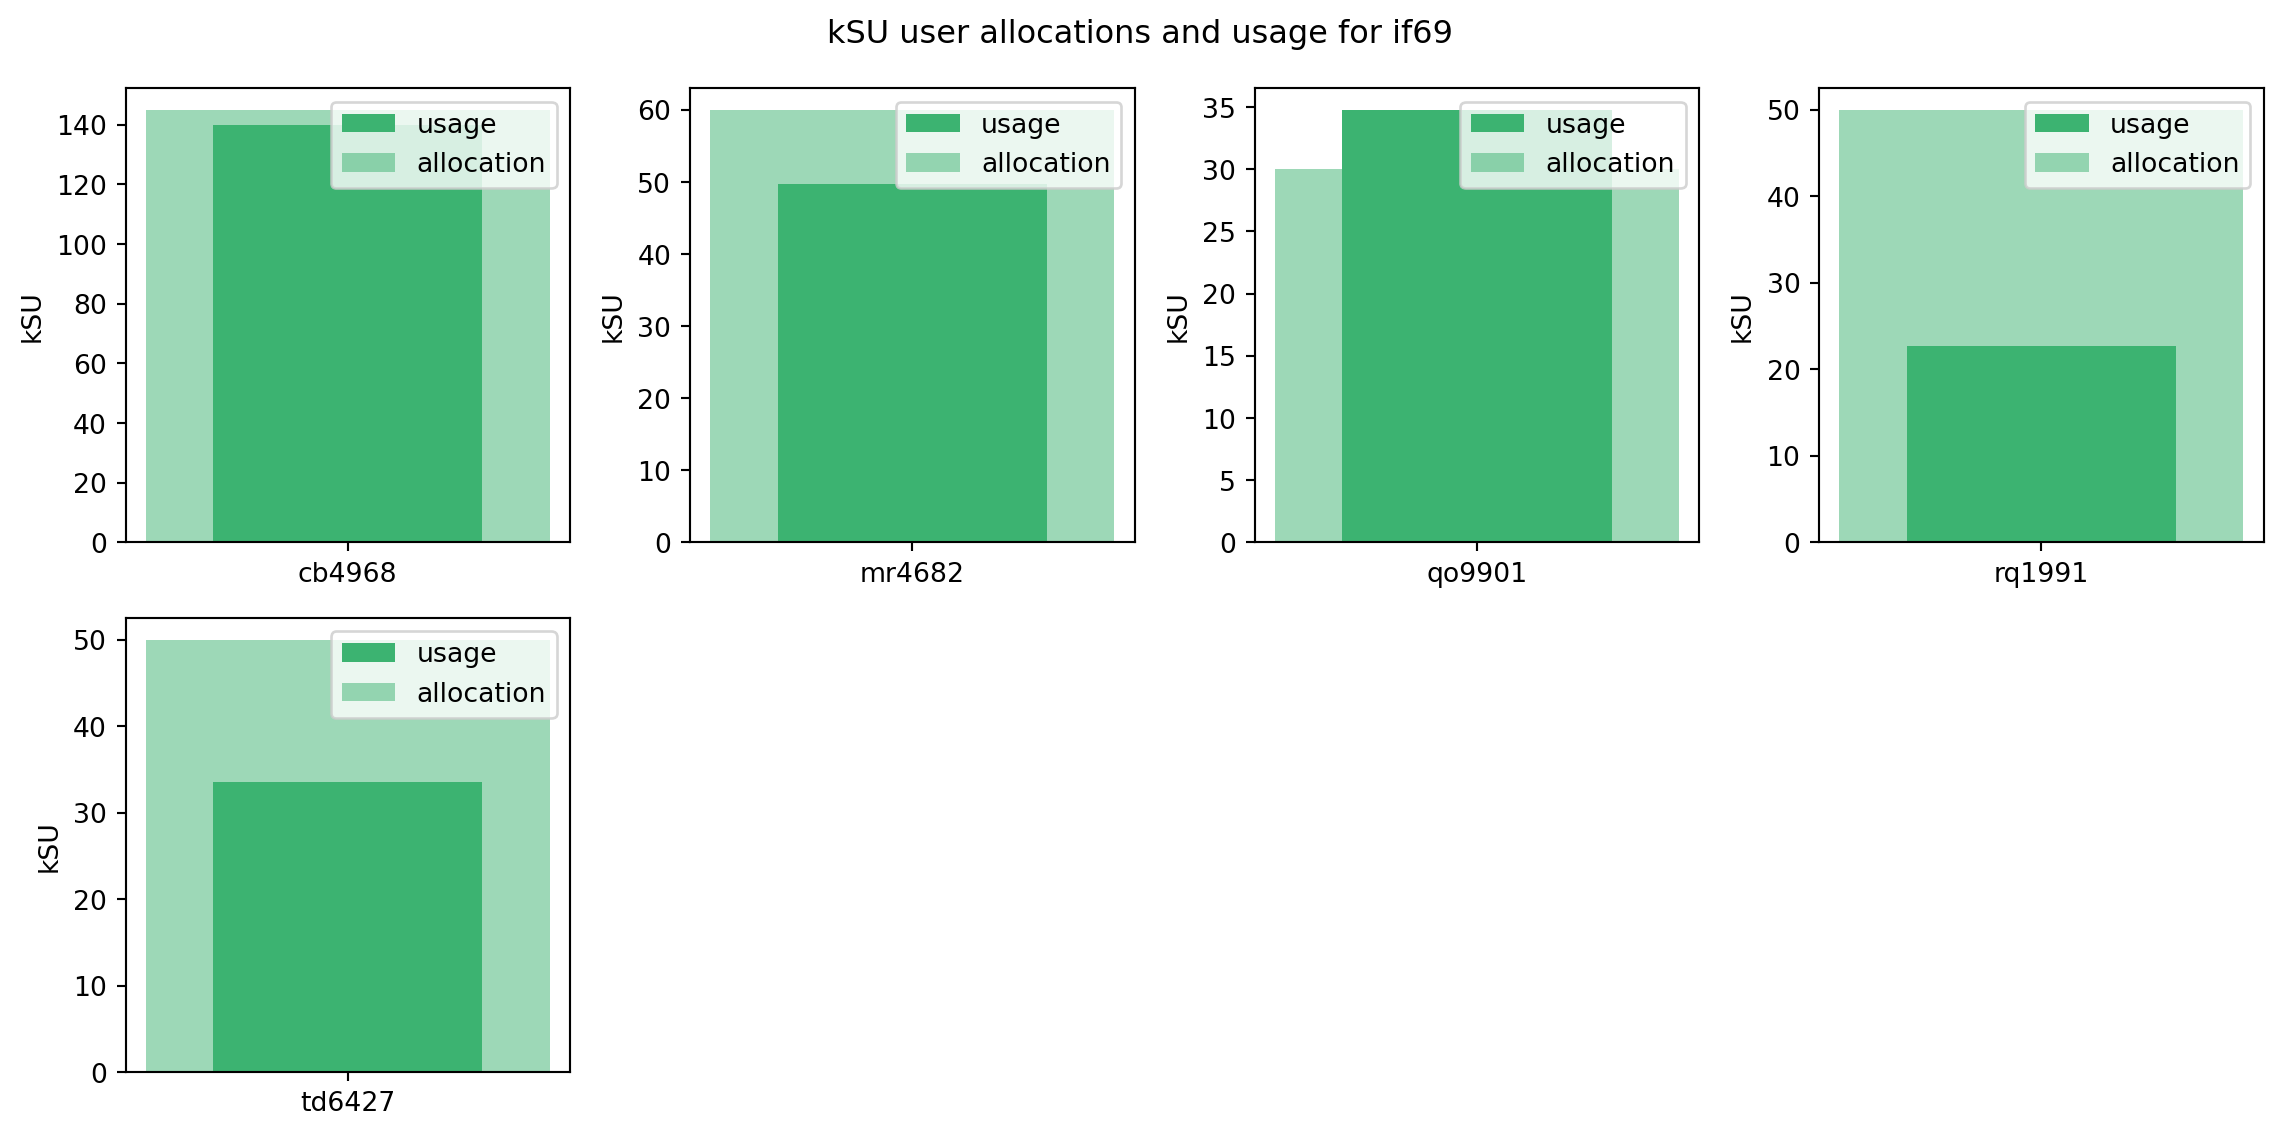

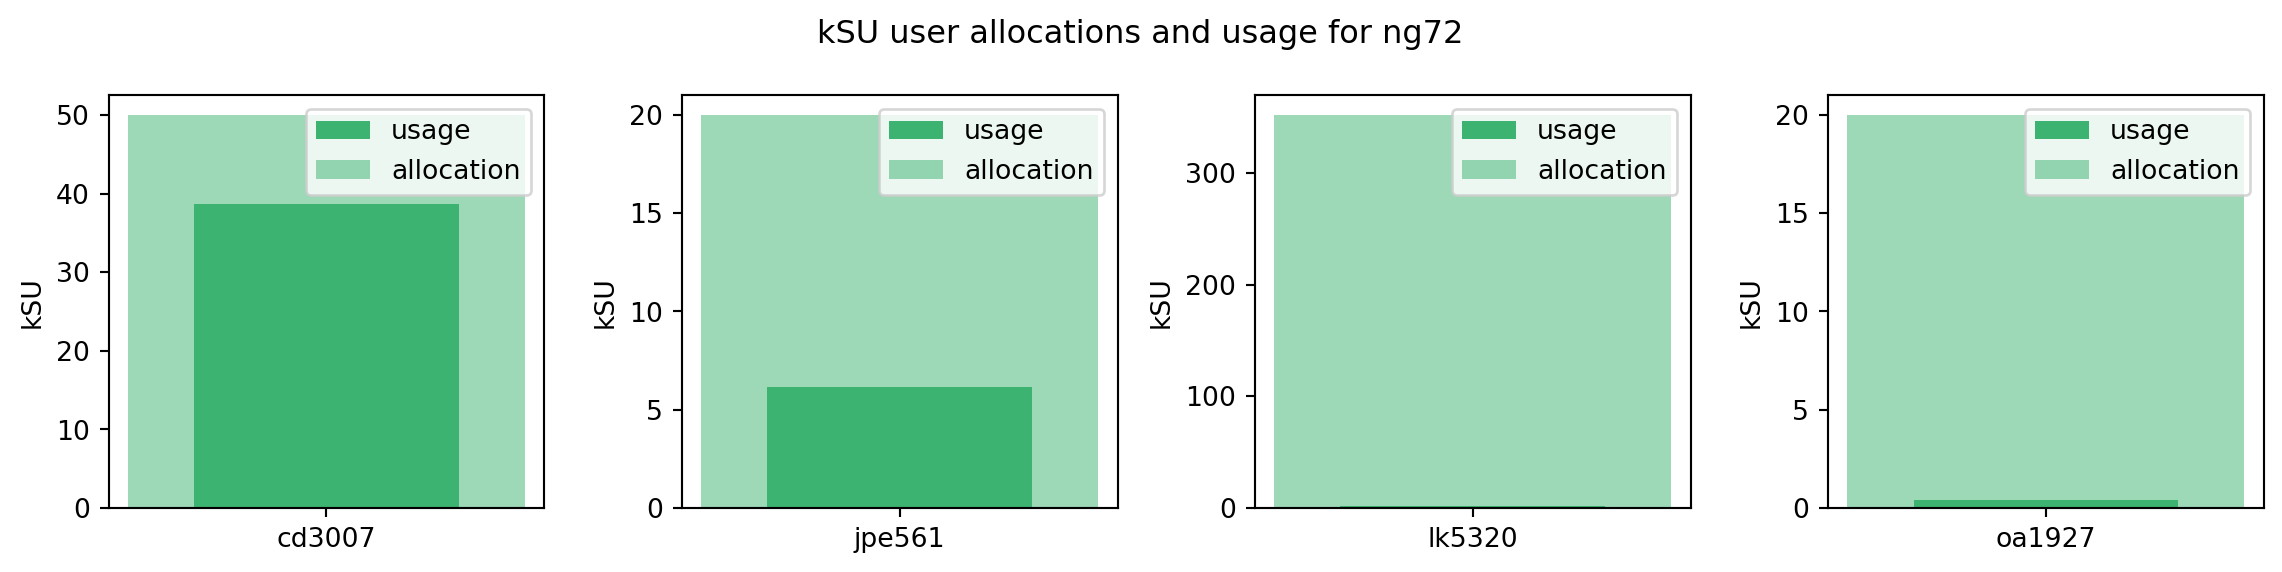

In [10]:
# Plot allocations for each user
for i,project in enumerate(grant_dict.keys()):
    num_columns=4  
    num_plots = len(alloc_df_dict[project].index)
    num_rows = int((num_plots-1)/num_columns+1)
    
    Position = range(1,num_plots+1)
    
    fig_height = num_rows*3
    fig_width = 12
    
    fig = plt.figure(figsize=(fig_width,fig_height))
    k = 0
    
    for user in alloc_df_dict[project].index:
        ax = fig.add_subplot(num_rows, num_columns, Position[k])
        ax.bar(x=[user],height=alloc_df_dict[project]['usage'].loc[user],width=0.2,label='usage',color='mediumseagreen')
        ax.bar(x=[user],height=alloc_df_dict[project]['allocation'].loc[user],alpha=0.5,width=0.3,label='allocation',color='mediumseagreen')
        ax.yaxis.set_label_text('kSU')
        ax.legend()
    
        k += 1
        
    _ = plt.suptitle(f'kSU user allocations and usage for {project}')
    plt.tight_layout()

#### Column {width=60%}

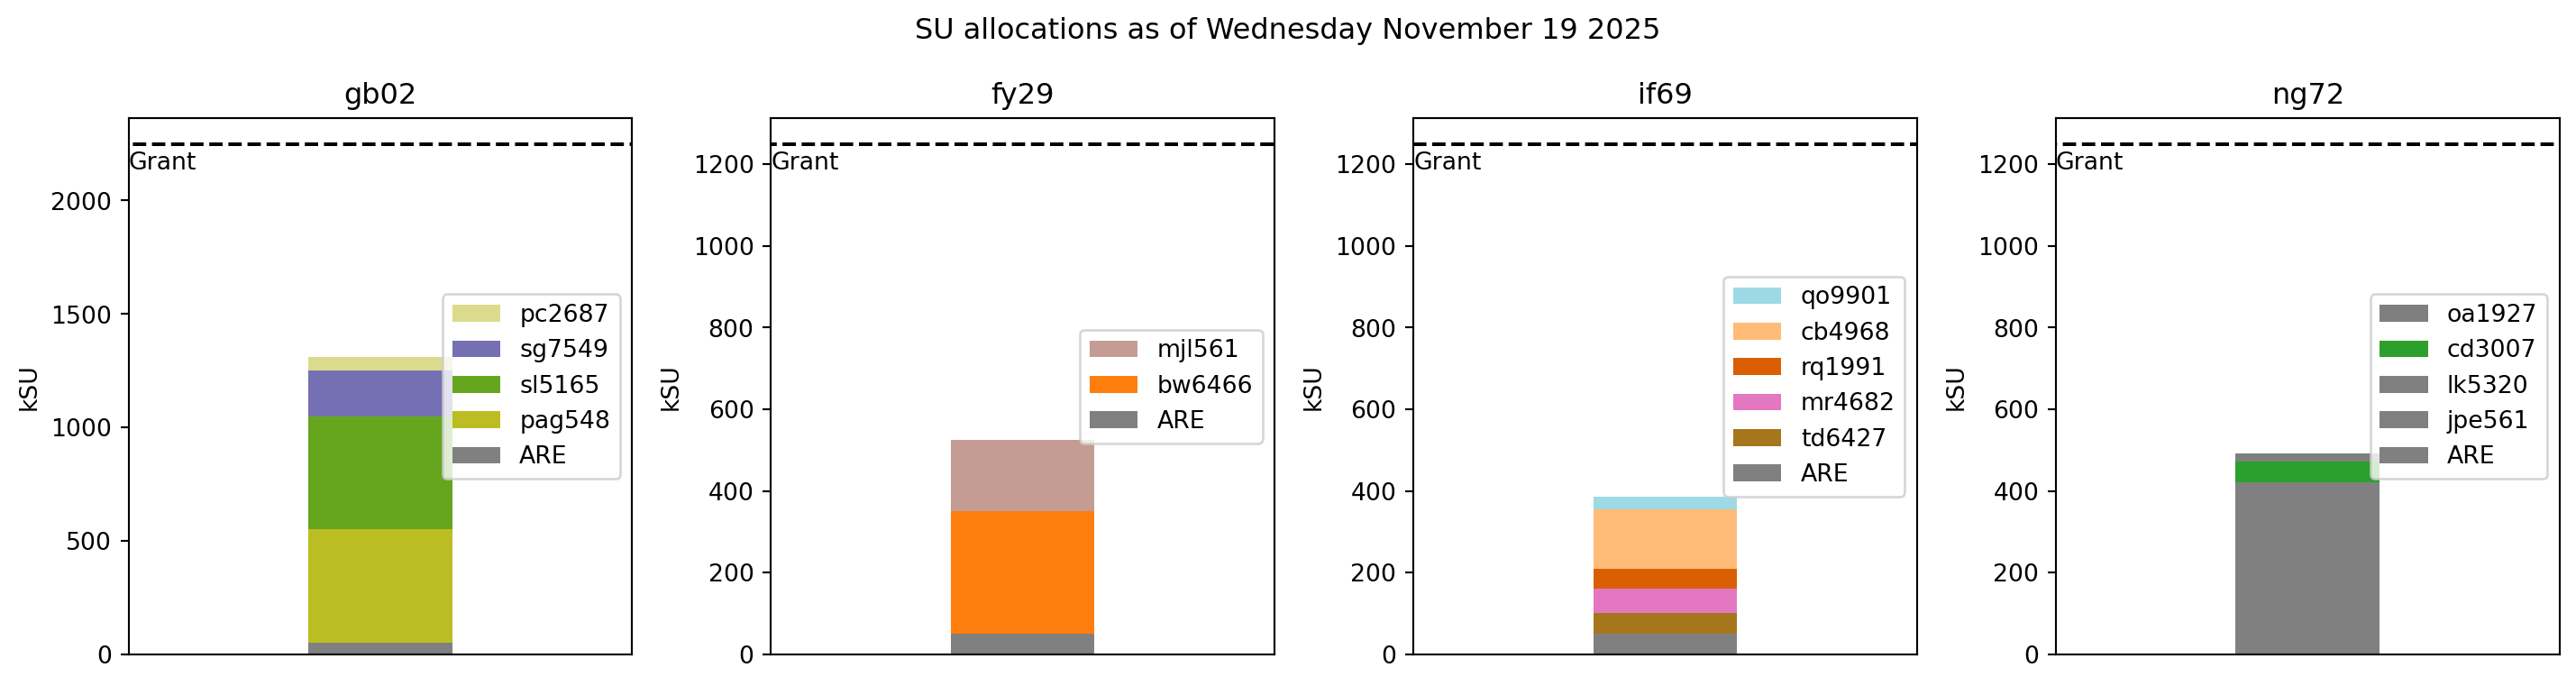

In [11]:
# Plot kSUs for every project
fig,axes = plt.subplots(1,len(grant_dict),figsize=(15,4))

USER_NAMES = 10  #Plot the top five usernames of SU usage


for i,project in enumerate(grant_dict.keys()):
    
    alloc_proj = allocation_df.xs(project, level='project')
    user_list = alloc_proj.index.tolist()
    bar_colors = [user_colors.get(user, default_color) for user in user_list]
    alloc_proj.T.plot.bar(
        stacked=True,
        ax=axes[i],
        width=0.2,
        color=bar_colors
    )
    patches, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles=patches[-USER_NAMES:][::-1],labels=labels[-USER_NAMES:][::-1],loc=7)
    axes[i].hlines(grant_dict[project],-5,5,linestyles='dashed',color='black')
    axes[i].annotate('Grant',(-0.35,0.95*grant_dict[project]))
    axes[i].yaxis.set_label_text('kSU')
    axes[i].xaxis.set_ticks([])
    axes[i].set_title(project)

_ = fig.suptitle(f"SU allocations as of {dt.datetime.today().strftime('%A %B %d %Y')}")
plt.tight_layout()

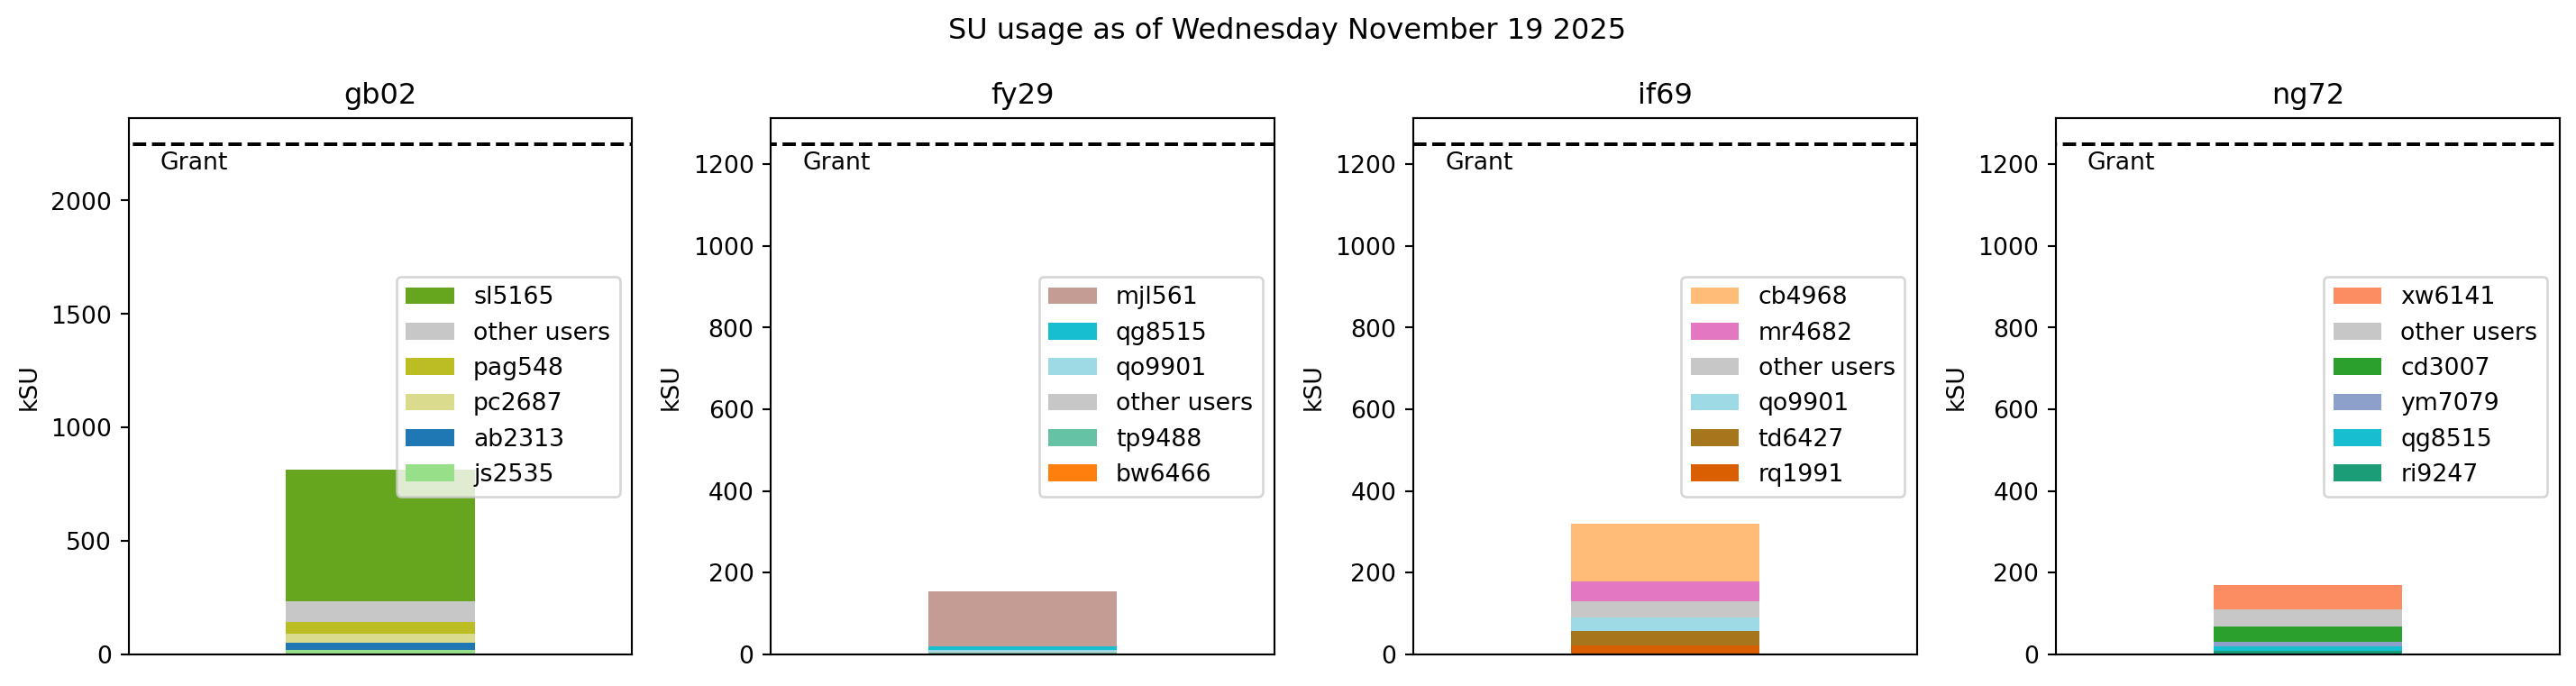

In [12]:
# Plot kSUs for every project
fig,axes = plt.subplots(1,len(grant_dict),figsize=(15,4))

USER_NAMES = 10  #Plot the top five usernames of SU usage

for i,project in enumerate(grant_dict.keys()):
    
    user_list = SU_df_dict[project].sort_values(ascending=True).index.tolist()
    bar_colors = [user_colors.get(user, default_color) for user in user_list]
    SU_df_dict[project].sort_values(ascending=True).to_frame().T.plot.bar(
        stacked=True,
        ax=axes[i],
        width=0.3,
        color=bar_colors
    )

    patches, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles=patches[-USER_NAMES:][::-1],labels=labels[-USER_NAMES:][::-1],loc=7)
    axes[i].hlines(grant_dict[project],-5,5,linestyles='dashed',color='black')
    axes[i].annotate('Grant',(-0.35,0.95*grant_dict[project]))
    axes[i].yaxis.set_label_text('kSU')
    axes[i].xaxis.set_ticks([])
    axes[i].set_title(project)

_ = fig.suptitle(f"SU usage as of {dt.datetime.today().strftime('%A %B %d %Y')}")
plt.tight_layout()

### SU by user

#### Column {width=70%}

In [13]:
itables.show(create_user_table(SU_df_dict1, 
                               allocation_df, 
                               default_limits={'gb02': 10, 'fy29': 10, 'if69': 10, 'ng72': 10}), 
    allow_html=True,
    columnControl=[
        {"target": 0, "content": ["order"]},
        {"target": 1, "content": ["search"]},
    ],
    ordering={"indicators": False, "handler": False},
    scrollY="600px", paging=False,
    columnDefs=[{"width": "40%", "targets": [4]}],
    style="width:100%;margin:auto",)


/g/data/gb02/pag548/venvs/xp65_extras/lib/python3.11/site-packages/itables/typing.py:203: SyntaxWarning:

These arguments are not documented in ITableOptions: {'info', 'lengthChange', 'searching', 'responsive', 'dom'}. You can silence this warning by setting `itables.options.warn_on_undocumented_option=False`. If you believe ITableOptions should be updated, please make a PR or open an issue at https://github.com/mwouts/itables

/g/data/gb02/pag548/venvs/xp65_extras/lib/python3.11/site-packages/itables/typing.py:203: SyntaxWarning:

These arguments are not documented in DTForITablesOptions: {'lengthChange', 'searching', 'dom', 'responsive', 'info'}. You can silence this warning by setting `itables.options.warn_on_undocumented_option=False`. If you believe ITableOptions should be updated, please make a PR or open an issue at https://github.com/mwouts/itables



Loading ITables v2.5.2 from the internet... (need help?)


#### Column {width=30%}

**How do I submit a compute allocation request?**

On Cumulus, reply to the thread ([`gb02`](https://21centuryweather.discourse.group/c/software-support/compute-requests-on-gb02/43), [`fy29`](https://21centuryweather.discourse.group/c/modelling-science/compute-requests-for-fy29/46), [`if69`](https://21centuryweather.discourse.group/c/centre-project-2-sst-movs-and-weather-systems/compute-requests-for-if69/49), [`ng72`](https://21centuryweather.discourse.group/c/high-impact-weather/compute-requests-for-ng72/48)) in the Compute Requests subcategory asociated to the NCI project you want to use. 


In you request, please include:

* your NCI username,
* how much compute you request,
* a short description what is it for, and
* (for gb02 requests) explain how your plans are relevant to the centre-wide project and how is of interest to a wide range of people in the centre.ople in the centre.

**Minimum compute allocation**

Any user can use up to certain about of compute per quarter without any request. Please, visit the thread asociated to each project to know more about the limits. 

**Calculate your SU usage**

You can calculate your SU usage with the [SU calculator app](https://paocorrales.shinyapps.io/SU_calculator/).

### Storage usage

In [14]:
storage_data = create_storage_df(storage_dict)

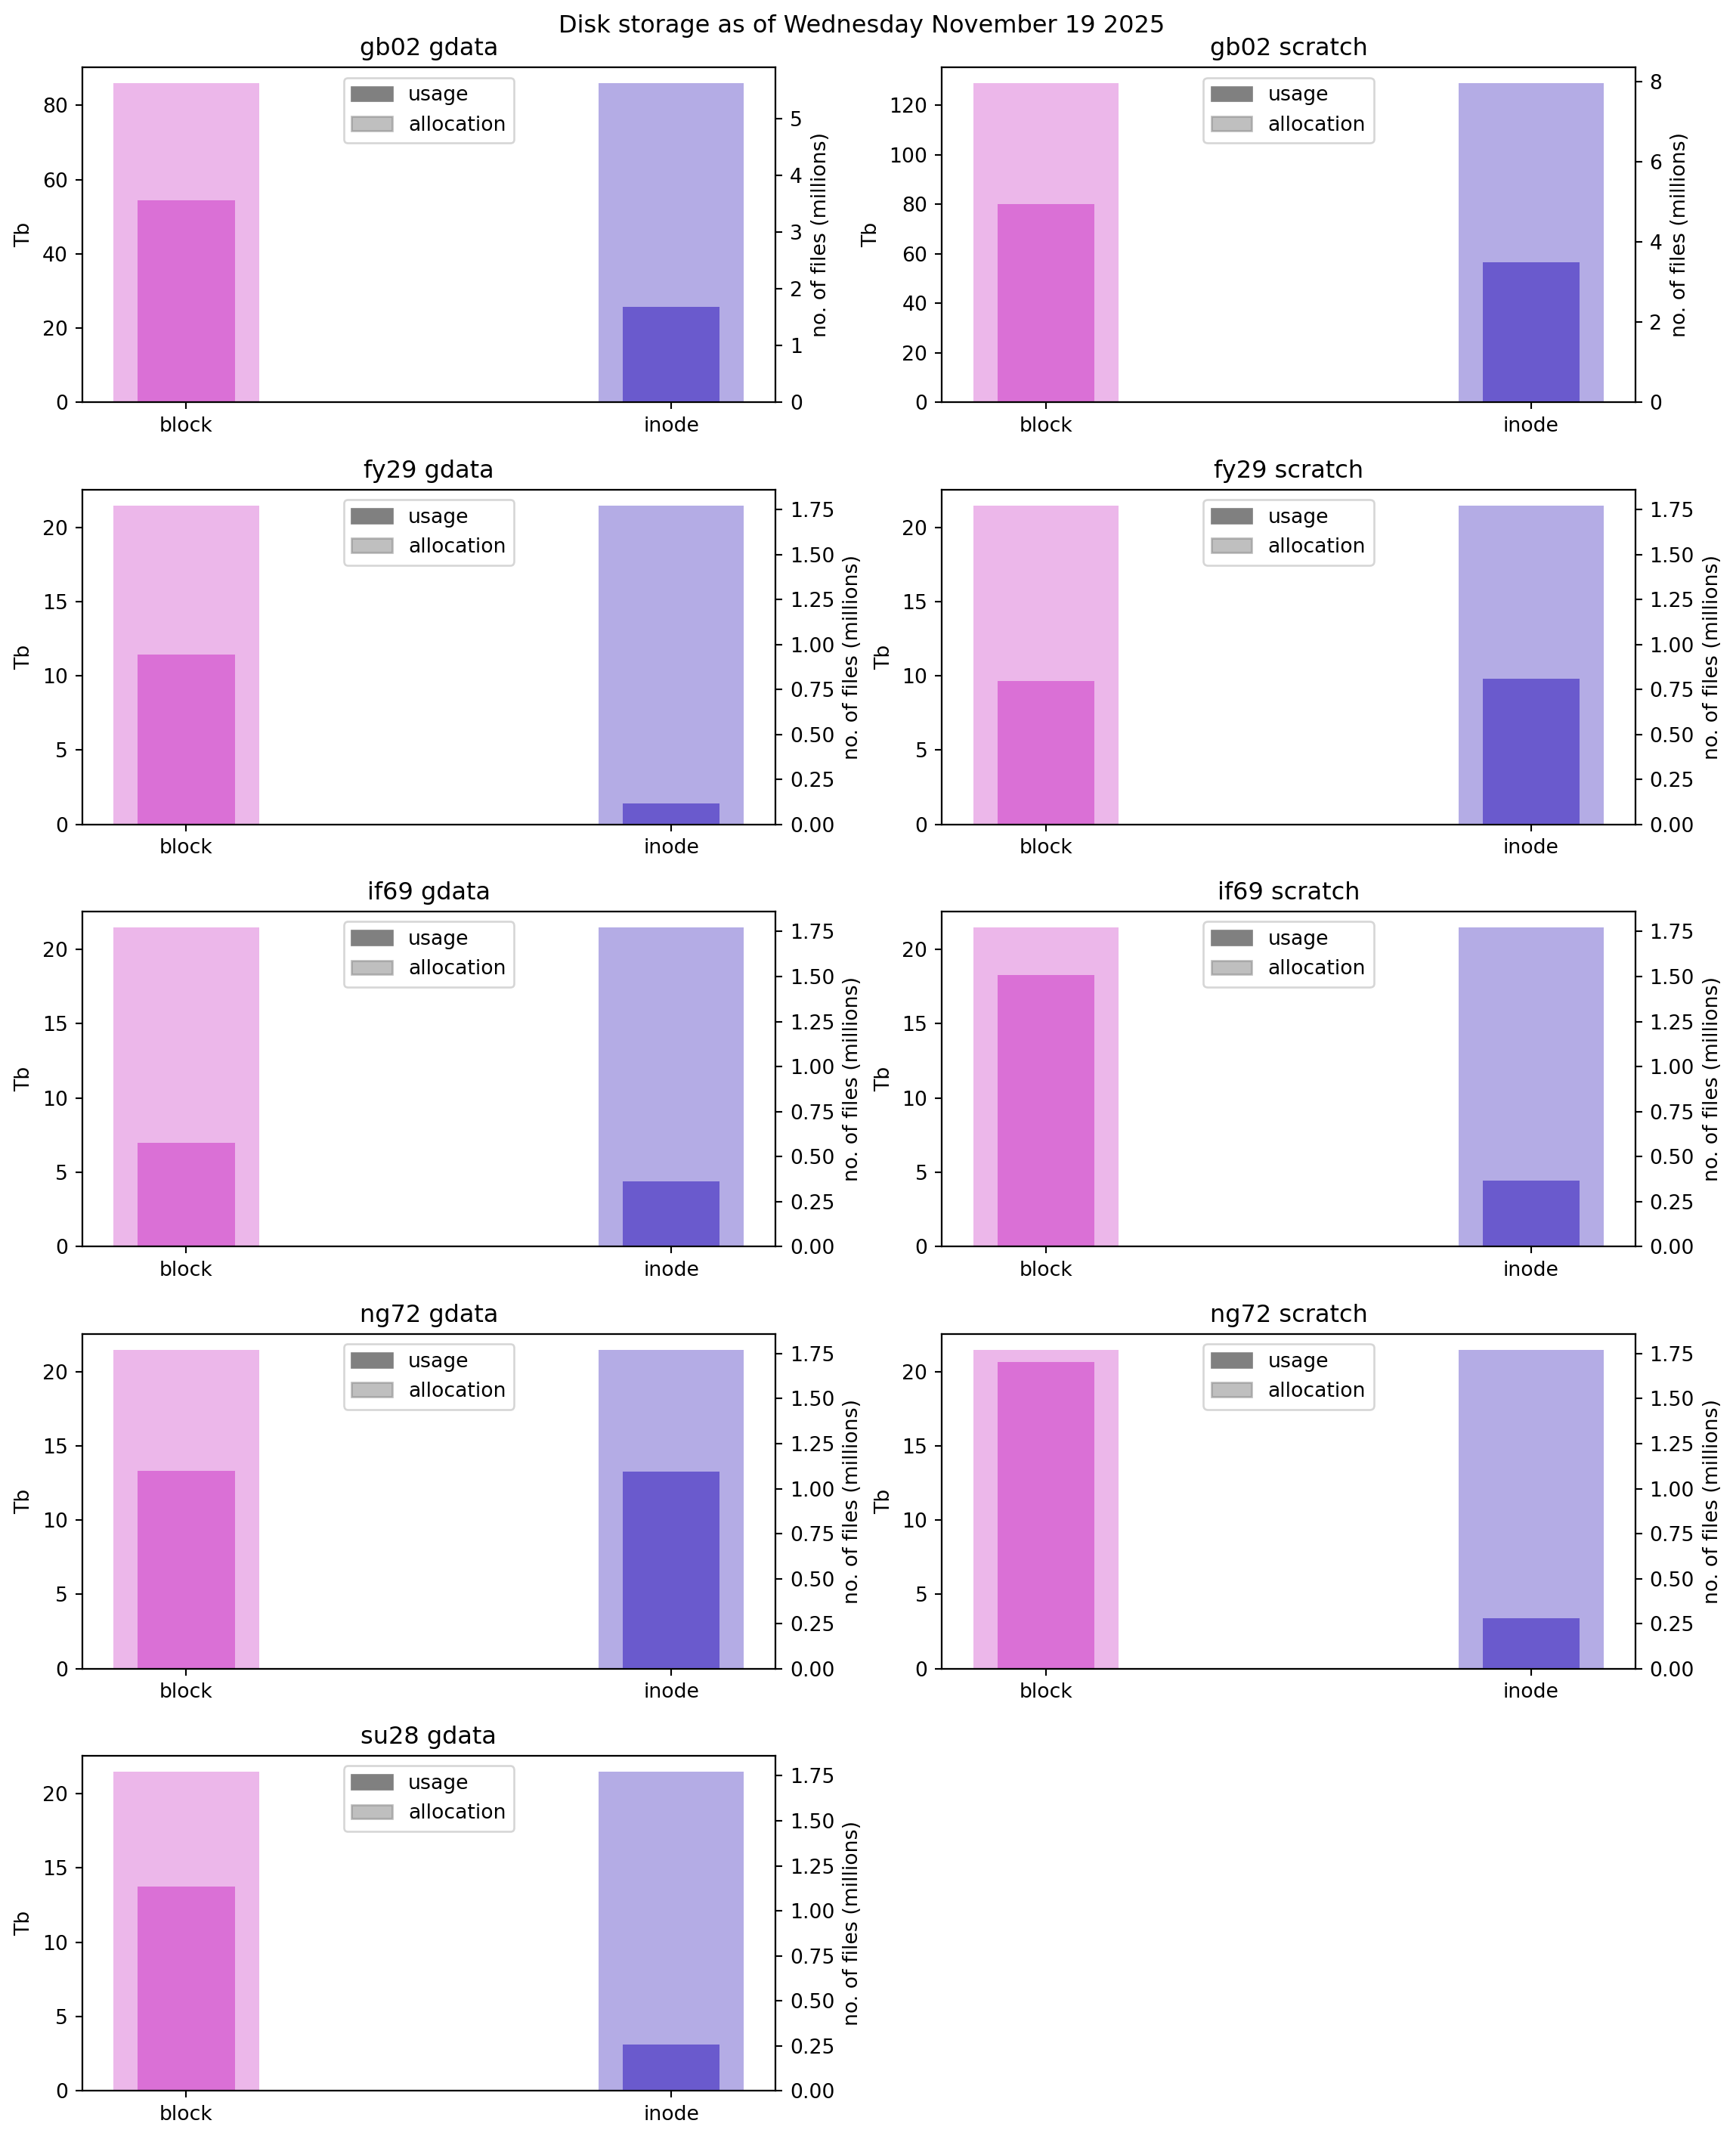

In [15]:
num_columns=2
num_rows = len(COE_PROJECTS)    
num_plots = sum(len(v) for v in storage_dict.values())
    
Position = range(1,num_plots+1)

fig_height = num_rows*3
fig_width = 12

fig = plt.figure(figsize=(fig_width,fig_height))
k = 0

for project in COE_PROJECTS:
    for disk in storage_data[project].keys():

        ax = fig.add_subplot(num_rows, num_columns, Position[k])
        ax.bar(x=['block'],height=storage_data[project][disk]['usage'].loc['block'],width=0.2,label='usage',color='orchid')
        ax.bar(x=['block'],height=storage_data[project][disk]['allocation'].loc['block'],alpha=0.5,width=0.3,label='allocation',color='orchid')
        ax2=ax.twinx()
        ax2.bar(x=['inode'],height=storage_data[project][disk]['usage'].loc['inode'],width=0.2,label='usage',color='slateblue')
        ax2.bar(x=['inode'],height=storage_data[project][disk]['allocation'].loc['inode'],alpha=0.5,width=0.3,color='slateblue',label='allocation')
        ax.yaxis.set_label_text('Tb')
        ax2.yaxis.set_label_text('no. of files (millions)')
        
        usage_patch=mpatches.Patch(color='grey',label='usage')
        alloc_patch=mpatches.Patch(color='grey',alpha=0.5,label='allocation')
        ax.legend(handles=[usage_patch,alloc_patch],loc=9)
        ax.set_title(f'{project} {disk}')

        k+= 1

_ = fig.suptitle(f"Disk storage as of {dt.datetime.today().strftime('%A %B %d %Y')}")
plt.tight_layout()

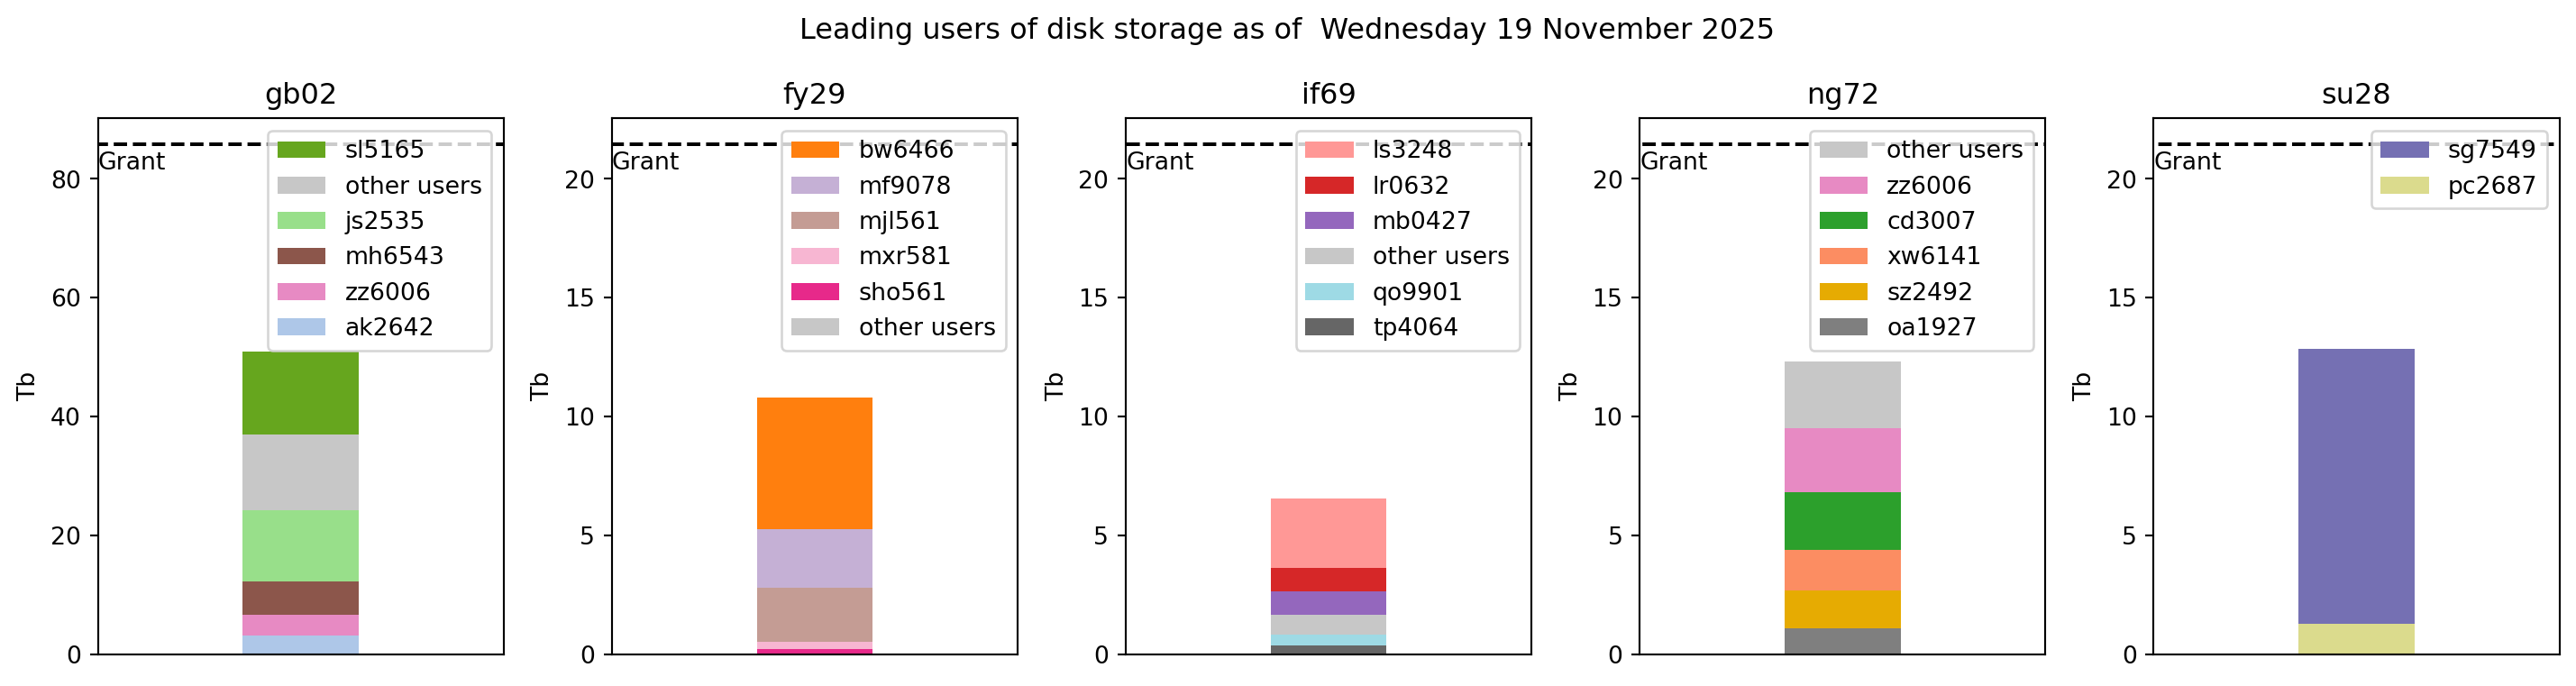

In [16]:
# Plot the five largest users for each project
fig,axes = plt.subplots(1,len(COE_PROJECTS),figsize=(15,4))

for i,project in enumerate(COE_PROJECTS):    

    user_list = user_storage_numeric[project].dropna().astype('int').sort_values().index.tolist()
    bar_colors = [user_colors.get(user, default_color) for user in user_list]

    (user_storage_numeric[project].to_frame().dropna().astype('int').sort_values('TOTAL SIZE')/1024**4).T.plot.bar(
        stacked=True,
        ax=axes[i],
        width=0.2,
        color=bar_colors
    )
    
    patches, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles=patches[-USER_NAMES:][::-1],labels=labels[-USER_NAMES:][::-1])
    axes[i].hlines(storage_data[project]['gdata']['allocation'].loc['block'] ,-5,5,linestyles='dashed',color='black')
    axes[i].annotate('Grant',(-0.35,0.95*storage_data[project]['gdata']['allocation'].loc['block'] ))
    

    axes[i].yaxis.set_label_text('Tb')
    axes[i].get_xaxis().set_ticks([])
    axes[i].set_title(project)

_ = fig.suptitle(f"Leading users of disk storage as of  {dt.datetime.today().strftime('%A %d %B %Y')}")
plt.tight_layout()

# Projects

| NCI Project  | Theme                           | Centre Projectcs                                      | NCI Project Lead  | SU/quarter + storage     |
|--------------|---------------------------------|-------------------------------------------------------|-------------------|------------------------|
| [gb02](https://my.nci.org.au/mancini/project/gb02)| Centre-wide Strategic Projects  | All              | gb02 Panel*       | 2.25 MSUs + 80 TB Storage |
| [fy29](https://my.nci.org.au/mancini/project/fy29)| High-Resolution Modelling       | Modelling        | Bethan White      | 1.25 MSUs + 20TB Storage  |
| [if69](https://my.nci.org.au/mancini/project/if69)| Circulation Change              | Weather System Dynamics, Variability & Warmer World,  | Chenhui Jin       | 1.25 MSUs + 20TB Storage  |
| [ng72](https://my.nci.org.au/mancini/project/ng72)| Weather Change                  | Weather Resources & High Impact Weather               | Andrew Brown      | 1.25 MSUs + 20TB Storage  |
| [su28](https://my.nci.org.au/mancini/project/su28) | Datasets for the Centre         | All                                                   | Sam Green         | 20 TB Storage          |

*gb02 panel: Navid Constantinou, Paul Gregory, Bethan White, Chenhui Jin, Andrew Brown, and Sam Green


Last update: `{python} dt.datetime.now().strftime("%d-%m-%Y %H:%m")`